<a href="https://colab.research.google.com/github/quangviet/python4engineer/blob/main/Problem_1/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Thông tin học viên**

Học viên: Phạm Quang Việt

Mã học viên: 22MSE23069

Email: viet22mse23069@fsb.edu.vn

#**Bài 1 - Python for Developers (MSE):**

Đọc hiểu tutorial One Tutorial to Understand All (M5-Forecasting) phần EDA trên Kaggle và chú thích lại bằng tiếng Việt.

### Về cuộc thi M5-Forecasting

Cuộc thi sử dụng data thu thập được từ dữ liệu thực tế của Walmart để dự báo lượng bán hàng trong 28 ngày tiếp theo.
Dữ liệu bao gồm khoảng 30,000 mặt hàng bán trong 1,900 ngày từ 3 bang của nước Mỹ. Các thông tin bao gồm giá, khuyến mãi, thời gian và các thông tin bổ sung khác như loại hàng hoá, cửa hàng etc.

### Mô tả vấn đề:

Để có thể dự đoán được lượng hàng hoá bán ra trong 28 ngày tiếp theo, các câu hỏi dạng SMART (cụ thể, đo đạc được, có thể đạt được,có liên quan và có giới hạn thời gian) sau cần được trả lời.

- Phân phối của sales_items(ids) theo từng categories?
- What is the behavior of categories across different stores?
- What specific item id is outselling the most? 
- What is the specific id of item in each category that has most sales?
- What is the most sales revenue collected? Is the item id that is outselling the most brings in the most revenue or is there variation along those trends?
- What is the behavior of total sales (or mean sales) across time
- What is the behavior of item_ids selling across different weekdays? Are there any specfic dates of the month when there are most sales?How does this trend change across different stores?

Do đề bài chỉ dừng lại ở bước trực quan hoá dữ liệu, mô hình dự đoán lượng hàng bán ra chưa được đề cập đến trong notebook này.

## Chuẩn bị dữ liệu

### Tải tập dữ liệu từ Kaggle
Sử dụng API của Kaggle để download data set và giải nén vào thư mục input

In [1]:
%env KAGGLE_USERNAME=quangviet
%env KAGGLE_KEY=e78ec69319c278806b1208176ad50255
!kaggle competitions download -c m5-forecasting-accuracy
!unzip -o /content/m5-forecasting-accuracy.zip -d ./input

env: KAGGLE_USERNAME=quangviet
env: KAGGLE_KEY=e78ec69319c278806b1208176ad50255
 72% 33.0M/45.8M [00:00<00:00, 49.0MB/s]
100% 45.8M/45.8M [00:00<00:00, 66.3MB/s]
Archive:  /content/m5-forecasting-accuracy.zip
  inflating: ./input/calendar.csv    
  inflating: ./input/sales_train_evaluation.csv  
  inflating: ./input/sales_train_validation.csv  
  inflating: ./input/sample_submission.csv  
  inflating: ./input/sell_prices.csv  


### Chuẩn bị các thư viện

Notebook này sử dụng các thư viện 
- Numpy - Xử lý dữ liệu mảng và đại số tuyến tính
- Pandas - Xử lý dữ liệu bảng và file csv
- Matplotlib - Trực quan hoá dữ liệu lên đồ thị
- Seaborn - Trực quan hoá dữ liệu thống kê
- Scipy - Thư viện khoa học, toán học
- Sklearn - Thư viện học máy
- Plotly - Vẽ đồ thị trực quan

Và một số thư viện hệ thống như time, math, datetime và các widget dùng để tương tác trực tiếp trong notebook


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input/sample_submission.csv
./input/sell_prices.csv
./input/sales_train_evaluation.csv
./input/calendar.csv
./input/sales_train_validation.csv


### Mô tả tập dữ liệu:

Notebook sử dụng các tập dữ liệu như sau

* `calendar_df.csv` - Thông tin ngày hàng hoá được bán cũng như thông tin về ngày lễ hoặc hoặc các dịp đặc biệt
* `train_sales_df.csv` - Thông tin về dữ liệu bán hàng trong quá khứ theo từng sản phẩm, cửa hàng và phòng ban trong 1900 ngày [d_1 - d_1913] 
* `submission_file.csv` - Chưa sử dụng trong notebook này 
* `sell_prices_df.csv` - Thông tin về giá sản phẩm bán ra theo của hàng và ngày bán
* `sales_train_evaluation.csv` - Thông tin bán hàng [d_1 - d_1941] (dùng cho bảng xếp hạng công khai)


### Đọc dữ liệu bằng pandas:

Pandas hỗ trợ đọc file dữ liệu format csv bằng pandas.read_csv()

In [3]:
sell_prices_df = pd.read_csv('./input/sell_prices.csv')
train_sales_df = pd.read_csv('./input/sales_train_validation.csv')
calendar_df = pd.read_csv('./input/calendar.csv')
submission_file = pd.read_csv('./input/sample_submission.csv')


### Hiển thị thông tin của tập dữ liệu:

Sử dụng pandas.core.frame.DataFrame.info() để lấy thông tin cơ bản của tập dữ liệu

In [4]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [5]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [6]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


Quan hệ giữa các cửa hàng, mặt hàng, nhóm hàng hoá cũng như số lượng hàng hoá bán được theo thời gian có thể được phân tích dựa trên các thông tin ở trên.

Tập dữ liệu sử dụng có khoảng 6 triệu bản ghi hàng hoá bán ra (thông tin từ 'sell_prices_df') với 30,000 loại hàng hoá khác nhau (thông tin từ 'train_sales_df')

Dựa vào thông tin từ tập dữ liệu 'calendar_df', phân tích dữ liệu theo thời gian có thể được thực hiện.

## *Phân tích dữ liệu khám phá (EDA):*

### Phân phối và sự thay đổi theo thời gian của các hàng hoá bán ra

Để tiện phân tích dữ liệu, thông tin ngày bán hàng ('d_1 tới d_1913') và các thông tin khách ('store_id', 'state_id') được tách ra.

In [7]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [8]:
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

#### Phân phối hàng bán ra theo chủng loại

In [9]:
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Phân phối hàng bán ra theo chủng loại')
fig.show()

Theo biểu đồ trên thì đồ ăn ('foods') là mặt hàng bán chạy nhất, tiếp thoel à đồ gia dụng ('household') và cuối cùng là mặt hàng giải trí ('hobbies')

In [10]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Phân bố mặt hàng bán ra theo từng bang')
fig.show()

Theo biểu đồ trên thì bang CA tiêu tiêu thụ số lượng hàng hoá nhiều nhất, tiếp theo đến bang TX và cuối cùng là bang WI

Để trực quan hơn, dữ liệu được chuyển sang đồ thị dạng cột và chia theo từng bang như bên dưới.

In [11]:
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

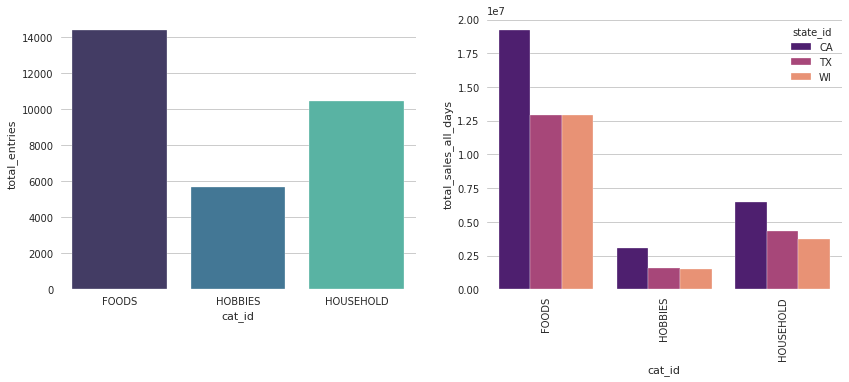

In [12]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)

plt.show()

Từ 2 đồ thị trên, có thể kết luận
- Nhóm mặt hàng bán ra nhiều nhất là thực phẩm ('foods'), tiếp theo đến 'household' và 'hobbies'
- Bang CA tiêu thụ nhiều sản phẩm nhất trên cả 3 nhóm hàng hoá. Bang WI tiêu thụ sản phẩm thực phẩm cao hơn bang TX và thấp hơn với 2 nhóm hàng hoá còn lại.

Phân phối lượng hàng hoá bán ra theo từng chủng loại và theo từng bang

In [17]:
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Phân phối lượng hàng hoá bán ra theo từng chủng loại và theo từng bang")


fig.show()

Theo đồ thị trên có thể thấy 
- Bang CA bán nhiều hàng hoá nhất
- Tổng lượng hàng hoá bán ra ở WI và TX là ngang bằng nhau

#### Phân bố hàng bán ra theo cửa hàng 

In [23]:
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [24]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Phân bố hàng hoá bán ra theo từng cửa hàng', 'Stores')
items_sold_per_days(df['state_id'], 'Phân bố hàng hoá bán ra theo từng bang', 'States')

Phân tích số liệu theo các biểu đồ trên cho thấy
- Hai nhóm mặt hàng bán chạy nhất là 'foods_3' và 'household_1'
- Phân bố hàng hoá bán ra theo cửa hàng ở 2 bang TX và WI không giống nhau mặc dù tổng sản phẩm bán ra trên từng chủng loại (category) có vẻ tương đương
- Cửa hàng bán chạy nhất ở các bang lần lượt là CA_3, TX_2 và WI_3

#### Hàng hoá nào bán chạy nhất

Vì tập dữ liệu 'train_sales_df' bao gồm thông tin về từng hàng hoá cụ thể và số lượng bán ra, ta có thể tìm hiểu mặt hàng nào bán chạy nhất.

Ta cũng có thể vẻ đồ thì biểu diễn kiểu phân bố hàng hoá bán ra trong ngày.

In [25]:
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

Theo kết quả bên trên, có thể thấy là khi gộp theo 'id' thì "**FOODS_3_090_CA_3_validation**" là bán chạy nhất, tiếp theo là **"FOODS_3_586_TX_2_validation"**. 

Sản phẩm đầu tiên thuộc nhóm hàng 'food_3' và bán ra ở cửa hàng 'CA_3'

Tương tự, sản phẩm thứ 2 thuộc về cửa hàng 'TX_2' và cùng thuộc nhóm hàng 'food_3'

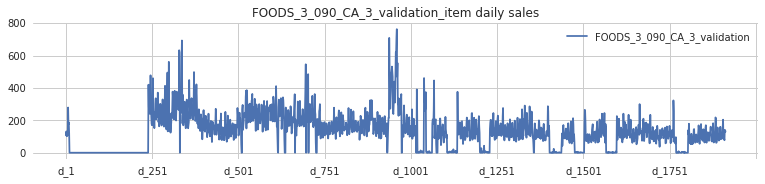

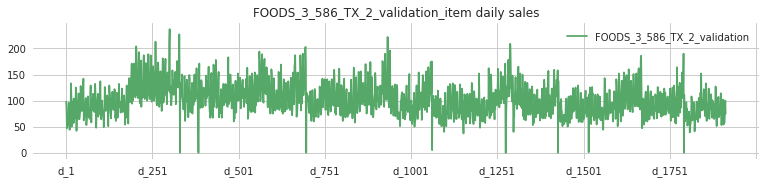

In [26]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

#### Mặt hàng bán chạy nhất trong từng nhóm hàng hoá

In [27]:
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


Sau khi tập dữ liệu đã được sắp xếp giảm dần theo số hàng hoá bán ra, ta có thể dễ dàng tìm ra sản phẩm nào bán chạy nhất trong từng nhóm hàng hoá (category)

In [34]:
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [35]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

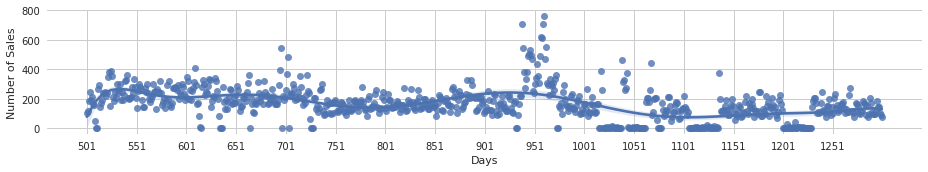

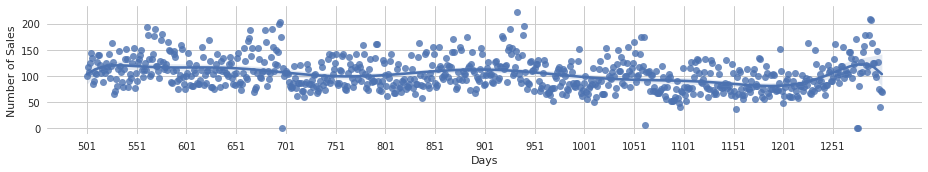

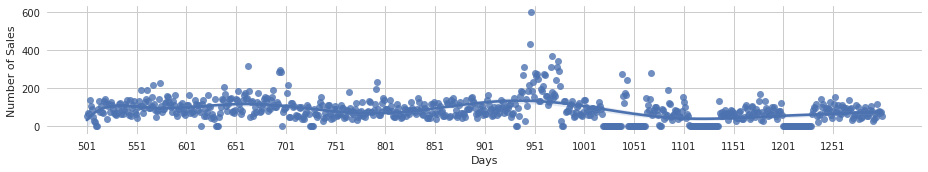

In [32]:
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)


Looking at the above graphs, our regression model does a fairly good job of fitting the line on the sales trend observed between the days 500th to 900th, for the item ids 'FOODS_3_090_CA_3_validation' and 'FOODS_3_586_TX_2_validation'. The graph also points out to the similar trends of troughs and crests between the specific days pointing out towards the occurence of special occasions and events that are driving sales. (To do _explain on order of polynomial and take more cases of ids across foods, household categories across different stores)

### Questions on Sales Revenue?

First of all, we'd be interested in finding out what the specific revenue with respect to each product is? But since we have not been provided the dataset with ids (product_ids) in sell_prices_df(revenue dataframe) and there is a mismatch in dataset entries between the both datasets (train_sales_df with almost 30000 rows and sell_prices_df with almost 6M entries), therefore, atbest, a rough estimate could be made by merging both datasets.

Frotunately enouhg, Revenue Dataframe (sell_prices_df) has the categorical level data available, so we could make an estimation regarding the items sold in each category to see what is the specific price where most items are getting sold. 

We'll first try fitting the non-parametric method of probability distribution since we suspect the data distribution might not be exact replica of a distribution we have seen before, and may include peaks or outliers. (https://machinelearningmastery.com/probability-density-estimation/)

If the behavior of data distribution does not resemble a known distribution, further investigation would be made to remove the specific data outliers

In [ ]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# making a new column category out of the item_id 
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

#### Distribution of Price Among Categories?

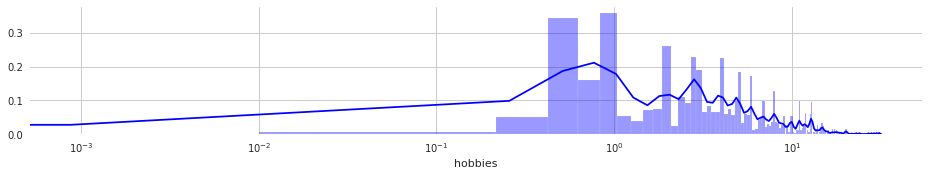

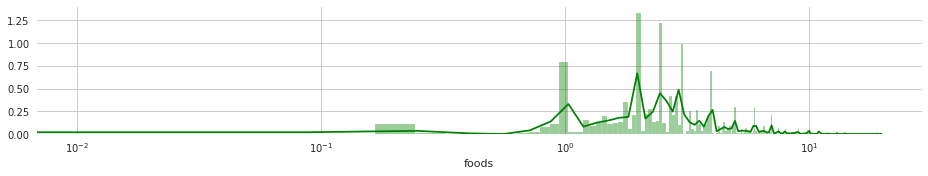

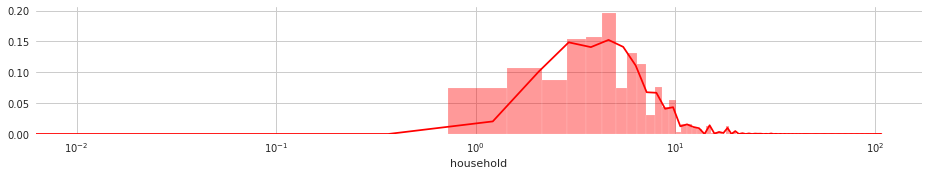

In [ ]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

We could extract following useful information by looking at these kde plots. 

- The probability distribution plot of the **household** items follows an almost normal distribution with a mean centered around a price of 5 Dollars and most items being sold within the 1 to 10 dollars range. This would indicate that most household items that are getting sold lie within the price bracket of 25 cents to 10 dollars
- **Foods** items prices is a multimodal distribution indicating frequent variation in interest among food items purchased. The values occur both towards the relative higher price bracket as well as lower price bracket indicating that the degree of interest of consumers in food items is not only varied but that the Walmart stores have a catalogue of food items that are peaking consumer's interest across different categories. The price bracket in this case also happens to lie within 2 cents to 10 dollars with only very few items getting sold past that range
- The probability distribution of **hobbies** related items prices indicates a mix of bimodal and multimodal distributions. This indicates that while a few items in specific category were sold more than others (first peak that lies in the area between 0.01 dollar to 1 dollar) there are also items towards a relative higher price bracket that have been also sold quite frequently enought to give it a multimodal distribution with small decreasing peaks indicative of decreasing interest in hobbies related items that are relatively expensive but sill significant enough to generate consumer interest. 

#### Removing Outliers to Observe Price Distribution? 
#### **Quartile Method**

In [ ]:
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

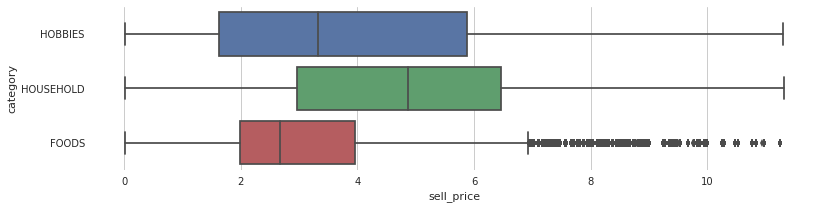

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

After removing most of the outliers, it is apparent that for 
- FOODS related items, 75 % of the items sold are those that are less than 4 dollars
- HOBBIES related items, 75 % of the items sold were less than 6 dollars with an mean price centered around 3.25-3.5 dollars
- HOUSEHOLD items, 75 % of the items sold were less than 6.5 dollars. 

It also represents that there are quite a few outliers in our price data. Since we had observed before using the kdeplots, that the distributions of the dataset were mostly skewed, we used the quartile method of removing the outliers. 

(https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/)

### Distribution of Sales On Weekdays & Special Occasions?

Our third dataset named, calendar_df, provides valuable information along the timeseries for the dataset of product_id. This dataset also contains information about Special occasions, SNAP (Supplementary Nutrition Assistance Programme) in the USA and coupled with the product_id dataset i.e. train_sales_df would be helpful in observing sales along weekdays, specific dates and special occasions

In [ ]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

Looking at the distribution of data in 'event_name_1' and 'event_type_1' it is clear the data here relates to holidays which could reveal important trends when coupled with the information of sales made on the specific event.

In [ ]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

It seems a few entries that have not been made to the 'event_name_1' attribute have been made available in a different category

In [ ]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

#### What are **SNAP_CA, SNAP_TX, SNAP_WI**?

SNAP stands for "Supplementary Nutrition Assistance Program" that is a federal level program aimed at providing food essentials to low-income households. This program is geared towards providing the food essentials and within the current dataset, the catagories of household items and hobbies items do not fall within the requirements of this program.

This program is only geared towards fighting the food hunger in america and only food related items can be purchased under this program

In [ ]:
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

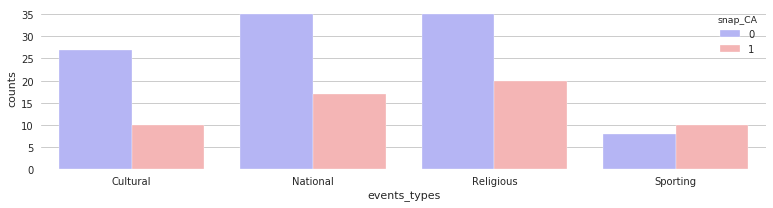

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [ ]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

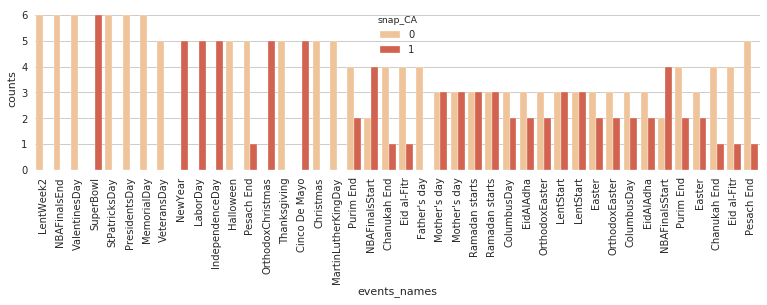

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

A look at both of these plots indicates the special occasions when the SNAP programme in CA were availed.  

### Distribution of Sales Items vs Sales Revenue? 
Now that we have product_id df as well as revenue_df, we'll merge the dataset now to start exploring trends of item_specific_data and sale_price_specific data 

In [ ]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', on='item_id', 
                                            left_index=True, right_index=True, 
                                            validate="1:1")


In [ ]:
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

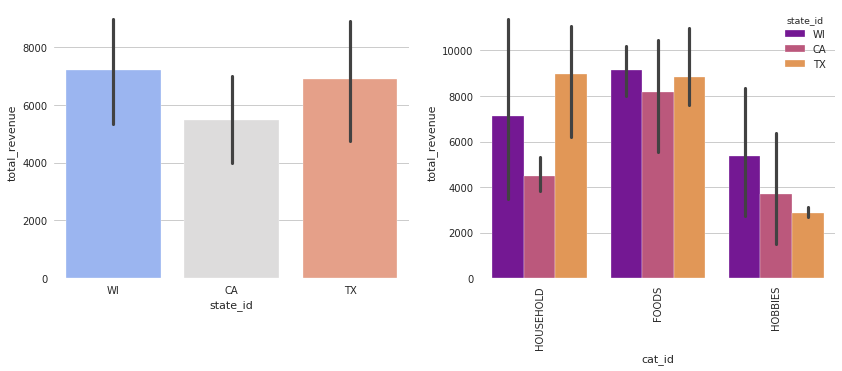

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

Despite the fact that salesprices data contains almost 6M entries, in the present case, we are only considering common entries between revenue df and product_ids df. A few significant insights have come forward, i.e. 

- Although we saw that california consistently was the one state where the unique product_id most sales were made, the most revenue collected came from the Wisconsin State stores
- Similarly, within the distribution of Categories, WI and TX contrinute more sales revenue than do the CA stores. 
- Wisconsin leads the revenue in FOODS and HOBBIES, while Texas leads the revenue in HOUSEHOLD
- CA tends to contribute the smallest revenue out of all three states, despite having the most sales of items in its stores locations

%%%%^^^^^^^^^!!!^^^^^^^^^%%%%%

In [ ]:
#train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d'), 
 #                                                                   left_index=True, right_index=True,
 #                                                                   validate="1:1").set_index('date')


In [ ]:
##train_sales_cal_df.T

### *Behaviour on TimeSeries & Analysis?*

Timeseries questions would involve merging the datasets of product_ids and data information to enable a thorough analysis through time. We could find out information on the sales of items alongside the timeseries and also find out what specific effects, the weekends and specials occasions might have had on number of units sold

**Rolling Averages** : Rolling averages are a useful tool to employ to understand the long term effects in a timeseries represented data. The rationale behind using rolling averages is the fact that resulting reading coming out of rolling averages smoothes out the data against daily fluctuations, and could help data professionals understand the long term impact of the sales/inventory across time. Therefore, we are going to use both rolling average as a necassary tool to help aid ou

#### Distribution of Total Sales Against Product_id on TimeSeries?

In [ ]:
#Changing the date type to datetime so that it is depicted as so:

#calendar_df.date = pd.to_datetime(calendar_df.date)
#type(calendar_df.date)

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)


In [ ]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [ ]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

From this graph it is difficult to tell the trend and seasonality patterns within our dataset. Althogh there is an increasing trend, the number of values for the entire dataset represented in the graph make it difficult to ascertain the true picture.

Fortunately, using the seasonal_decompose module in statsmodel, we could find out the seasonality and trend patterns in the timeseries. We are going to choose the "mulitplicative seasonality" owing to the fact of variability in the magnitude of the number of sales along the timeseries


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

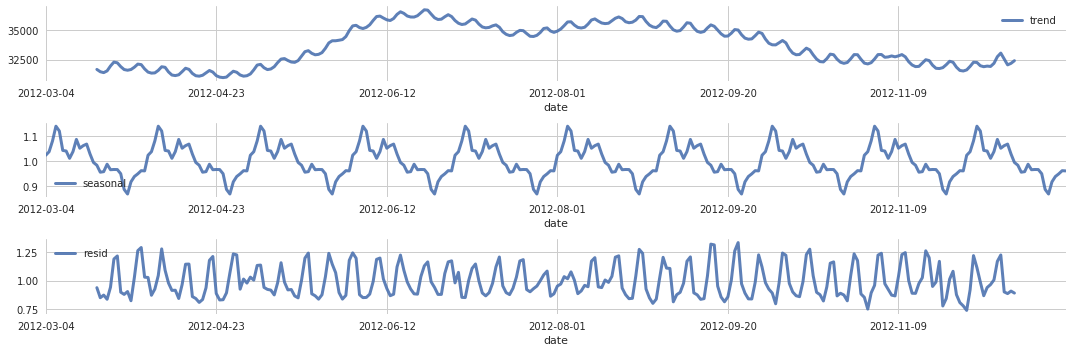

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

fter looking at the trend, the seasonality and residuals patterns, we have the following information gathered:

* There is definitely seasonality in our dataset, and in order to observe its pattern, we have taken a subset of dataset
* Since the seasonal and residual components are changing the trend line by an amount that is 'Dependent" of the changes in seasonal and residual components, we have a multiplicative behaviour

In [ ]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [ ]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

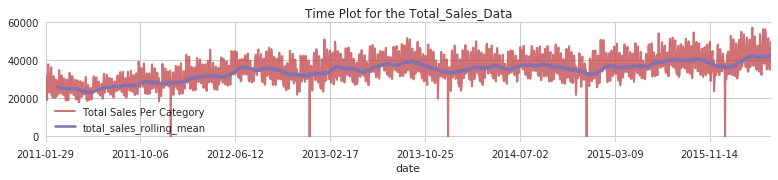

In [ ]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

Looking at the graph, it is obvious that the unit sales across timeline have been on a steady increase. This would imply that 

* There are items remaining in inventory must be tracked
* We could plot a sales of a few items to see how the behavior of each one fares across timeline. 

In [ ]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum(axis=1).sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [ ]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum(axis=1).sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

So, out of the most popular categories of 25 most sold items, more items had been sold in Texas than in either California or Wisconsin

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

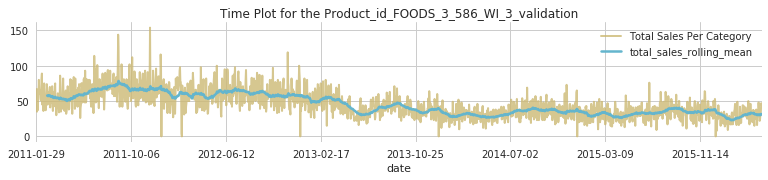

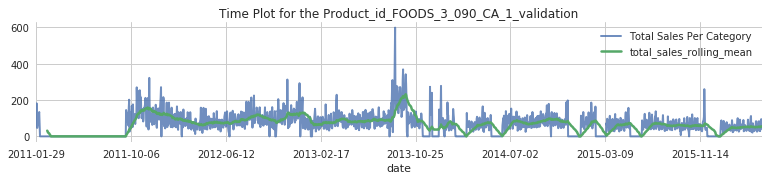

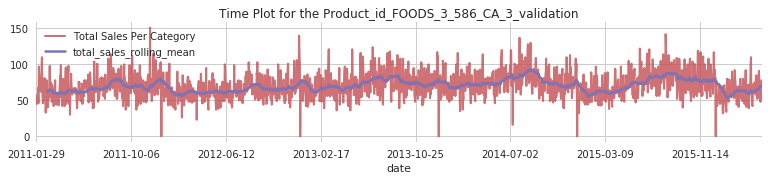

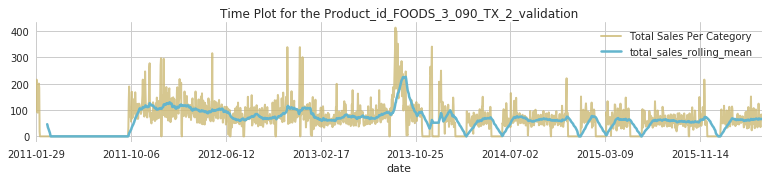

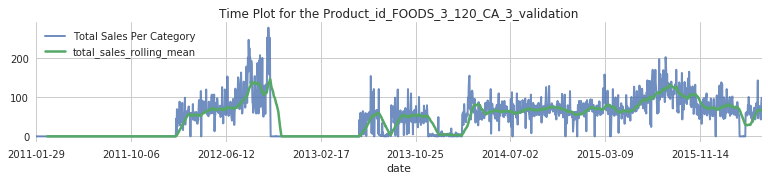

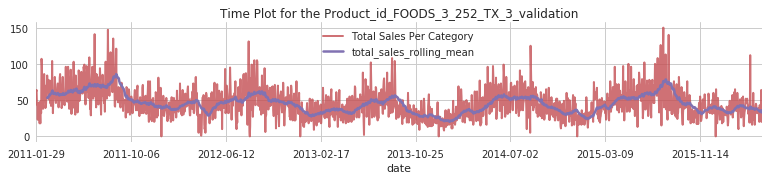

In [ ]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

### Distribution of Total Sales Against Each Category?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [ ]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

The results of the plot indicate that:

* There is defintely an increase in the number of items being sold with time
* The items sold in the Food and Household category have seen a more gradual increase than those of hobbies related items.

#### Distribution of Total Sales Sold Per State?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum(axis=1).T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [ ]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

While there has been an increase in the number of sales across all three states i.e. CA, TX, and WI interesting to note is the fact that:

* There is an overall increase in the sales of items across all states
* WI sales cross TX sales at around Oct'14 and Sept'15 indicating that that could be boost in the sales of category of items that are seasonal. We'll try and investigate the sales of categories across separate states to further shed a light on this answer

In [ ]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum(axis=1).T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:617: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
#train_sales_cal_df = train_sales_cal_df.set_index('dates')

In [ ]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

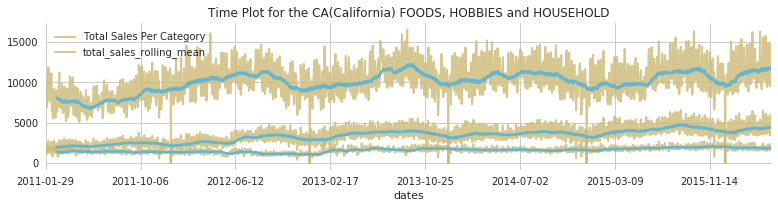

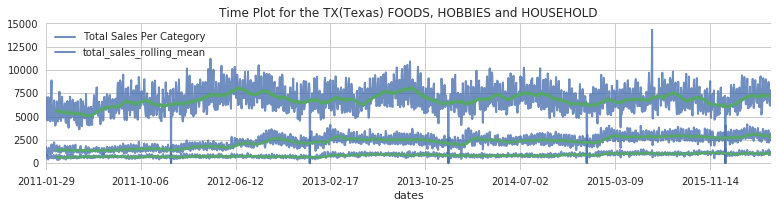

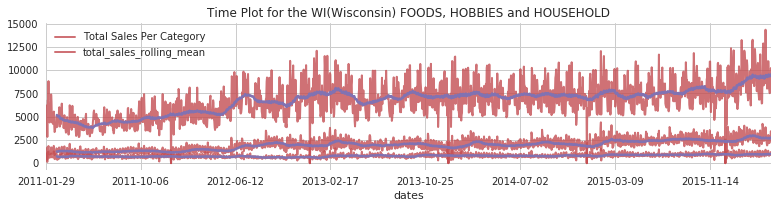

In [ ]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

By looking at the above graphs, some of the trends regarding in the food distribution category along separate states have become evident. 

* Along the FOODS distribution, both CA and TX see large bumps in sales around june'12 and september'12-October'12 with the next peak coming around in Oct'13 that is larger than the sales in June'12 with the same trend continuing to repeat itself along other dates in 2014, and 2015
* However, the sales along WI stores have a slightly different pattern with peaks of sales occuring in July'12 and next largest being observed in Feb-Mar'13. Similarly, the sales pick up around September in 2013, and then in Mar'13

* In Household items distribution, the peaks of sales across all stores in CA, TX and WI occur around July, March while relatively huge dips in sales occuring in all three locations around the month of Jan-Feb. 

* In Hobbies items sales, there is surprising peak in sales (albiet different in actual number of units sold) across similar dates in all store locations (for example Feb'13 and Feb'15) with a slight dip in sale in Aug-Sep'13.

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)


In [ ]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


These are the five item ids that have been selling most in California and Texas locations.
* While the first one "FOODS_3_090_CA_3_validation" is the same as the one that was most sold during our earlier analysis, the second observation is quite different to earlier assessment and the item most sold in second place has id "FOODS_3_281_CA_3_validation"
* The items that were contributing to the sales bump of household items are also mentioned above. The household item sold most during the bump period is HOUSEHOLD_1_334_CA_3_validation 

### Distribution of Total Sales Vs Store_ID?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum(axis=1)\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#PLOT one by one to avoid memory overload

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

Looking at the above plot with respect to specific stores, it is indicative that:

* CA_3 store location has the most items sold
* CA_4 store location has the least items old across the timeline
* TX_2 has the most items sold across timeline with most items sales peaking around Sep'13
* All Texas store locations (TX_1, TX_2, TX_3) experience a boost in sales around Feb_Mar'15 , with a peak around August'15 and then bottom out around Dec'15
* Wisconsin Store locations experience a rather unpredictable pattern
* Store WI_2 accelerates past the sold of WI_3 in Dec'12 and then continues to maintain the lead
* Stores WI_2, WI_1 were underperformers in the beginning but experienced a boost in sales July'12 and November'12 respectively
* There appears to be a continuous decline in the performance of sold items for the store location WI_3 that are only relatively improved towards the end

### Distribution of Sales Per Specific Days/Weekends?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')


In [ ]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [ ]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')